0:	learn: 0.6017743	test: 0.5631970	best: 0.5631970 (0)	total: 195ms	remaining: 1m 37s
50:	learn: 0.6756039	test: 0.6086769	best: 0.6087588 (45)	total: 2.1s	remaining: 18.5s
100:	learn: 0.6822245	test: 0.6092817	best: 0.6094796 (62)	total: 4s	remaining: 15.8s
150:	learn: 0.6837473	test: 0.6108649	best: 0.6114948 (141)	total: 5.92s	remaining: 13.7s
200:	learn: 0.6853552	test: 0.6109216	best: 0.6114948 (141)	total: 7.84s	remaining: 11.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6114947659
bestIteration = 141

Shrink model to first 142 iterations.

✅ Evaluation Metrics:
Accuracy: 0.6256
F1 Score (weighted): 0.6246712724081553
Precision (weighted): 0.6249425781271534
Recall (weighted): 0.6256
ROC AUC (OvR): 0.7698592060861271

📊 Classification Report:
              precision    recall  f1-score   support

        High       0.63      0.56      0.59      3762
         Low       0.65      0.69      0.67      8509
    Moderate       0.59      0.59      0.59      77

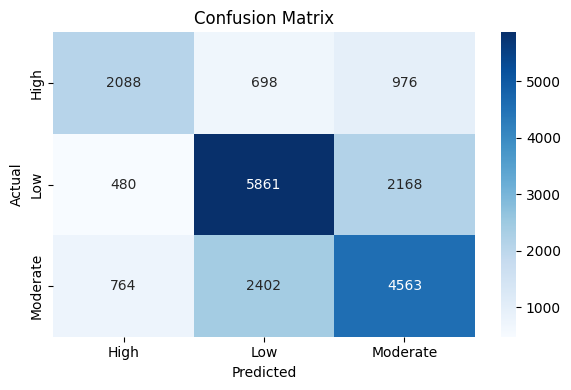

In [1]:
# STEP-0: Install required packages if not already installed
# pip install catboost scikit-learn matplotlib seaborn

import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# STEP-1: Load your data
train_df = pd.read_csv("D:\Realistic_Significant_Diabetes_100K_TrulyUnique.csv")
test_df = pd.read_csv("D:\Realistic_Significant_Diabetes_20K_Batch2_Unique.csv")

# STEP-2: Drop non-feature column
train_df.drop(columns=["PatientID"], inplace=True)
test_df.drop(columns=["PatientID"], inplace=True)

# STEP-3: Encode target
le = LabelEncoder()
train_df['DiabeticRisk'] = le.fit_transform(train_df['DiabeticRisk'])
test_df['DiabeticRisk'] = le.transform(test_df['DiabeticRisk'])

# STEP-4: Identify features and categorical features
target = "DiabeticRisk"
features = [col for col in train_df.columns if col != target]
cat_features = train_df[features].select_dtypes(include='object').columns.tolist()

# STEP-5: Fix NaNs for CatBoost (string for categorical)
for col in cat_features:
    train_df[col] = train_df[col].astype(str).fillna("nan")
    test_df[col] = test_df[col].astype(str).fillna("nan")

# STEP-6: Create Pool objects for CatBoost
train_pool = Pool(train_df[features], train_df[target], cat_features=cat_features)
test_pool = Pool(test_df[features], test_df[target], cat_features=cat_features)

# STEP-7: Define and train model
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1.5,
    bootstrap_type="Bayesian",
    bagging_temperature=1.0,
    rsm=0.9,
    loss_function="MultiClass",
    eval_metric="Accuracy",
    custom_metric=["F1", "Precision", "Recall", "AUC"],
    od_type="Iter",
    od_wait=100,
    auto_class_weights="Balanced",
    one_hot_max_size=3,
    random_seed=42,
    verbose=50
)

model.fit(train_pool, eval_set=test_pool)

# STEP-8: Predict and evaluate
y_pred = model.predict(test_df[features])
y_proba = model.predict_proba(test_df[features])
y_true = test_df[target]

print("\n✅ Evaluation Metrics:")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))
print("Precision (weighted):", precision_score(y_true, y_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_true, y_pred, average='weighted'))
print("ROC AUC (OvR):", roc_auc_score(y_true, y_proba, multi_class='ovr'))

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# STEP-9: Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


          Feature Id  Importances
0                BMI    30.259159
1       BloodGlucose    24.249926
2   WaistHeightRatio    11.335778
3          HeartRate     7.051304
4        StressLevel     6.891096
5   PhysicalActivity     6.737117
6   Fatigue_Weakness     6.564356
7       SleepQuality     6.498174
8               Diet     0.078021
9           Location     0.075020
10               Age     0.073276
11   Diabetes_Family     0.071329
12     Socioeconomic     0.043529
13            Gender     0.041670
14           Smoking     0.010980
15           Alcohol     0.010662
16           Tobacco     0.008602


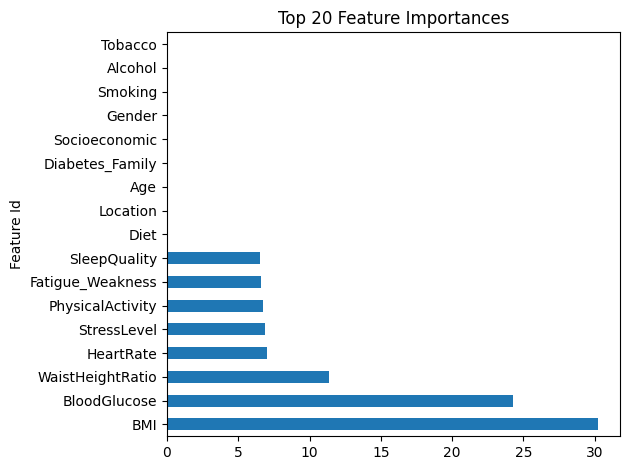

In [2]:
import matplotlib.pyplot as plt

feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance)

# Plot top 20
feature_importance[:20].plot(kind='barh', x='Feature Id', y='Importances', legend=False)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()
